<a href="https://colab.research.google.com/github/tmtakashi/signal_processing/blob/master/filtered_reference_LMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 音響環境制御特論　課題２


2DS19018R 皆川孝志

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, firwin

In [0]:
fs = 10000 # sampling frequency
alpha = 0.001 # step size parameter
duration = int(10 * fs) # create signal with length １０[s]
numtaps = 256 # length of FIR filter

np.random.seed(0)

## 必要なフィルタの定義

### バンドパスフィルタ (50Hz ~ 250Hz、騒音信号用のフィルタ)

In [0]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

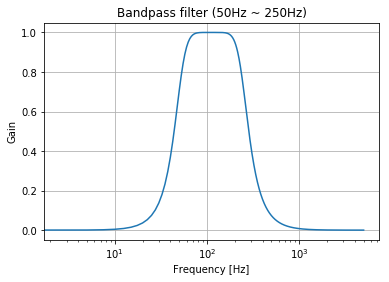

In [4]:
lowcut = 50.0
highcut = 250.0

b, a = butter_bandpass(lowcut, highcut, fs, order=3)
w, h = freqz(b, a, worN=2000)
plt.plot((fs * 0.5 / np.pi) * w, abs(h))
plt.title('Bandpass filter (50Hz ~ 250Hz)')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.ylabel('Gain')
plt.grid(True)

In [0]:
x = np.random.randn(duration)
d = butter_bandpass_filter(x, lowcut, highcut, fs, order=3)

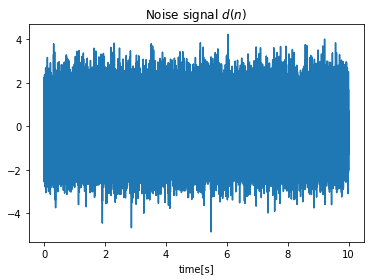

In [6]:
t = np.linspace(0, 10, duration)
plt.plot(t, x)
plt.title('Noise signal $d(n)$')
plt.xlabel('time[s]')
plt.show()

### ローパスフィルタ　（音場特性のモデル、カットオフ周波数500HzのFIRフィルタ）

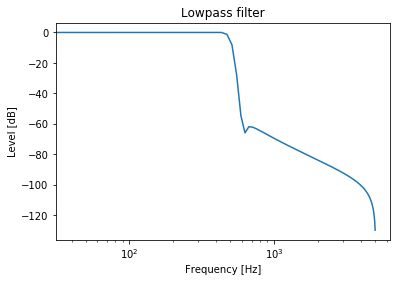

In [7]:
lowcut = 500
g = firwin(numtaps, lowcut, fs=fs)
G = np.fft.fft(g)
plt.plot(np.linspace(0, fs//2, len(G)//2), 20*np.log10(np.abs(G)[:len(G)//2]))
plt.title('Lowpass filter')
plt.xscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Level [dB]')
plt.show()

## 定式化で用いる理想的な状況の場合

$$
e(n) = d(n) + w * G * x(n)
$$

In [0]:
w = np.random.randn(numtaps) # FIR filter
e = np.zeros(duration) # Error signal (10s)
alpha = 0.001 # step size

In [0]:
r = np.convolve(g, x)

for i in range(0, duration - numtaps):
    e[i] = d[i] + np.dot(w.T, r[i : i + numtaps])
    w = w - alpha * r[i : i + numtaps] * e[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


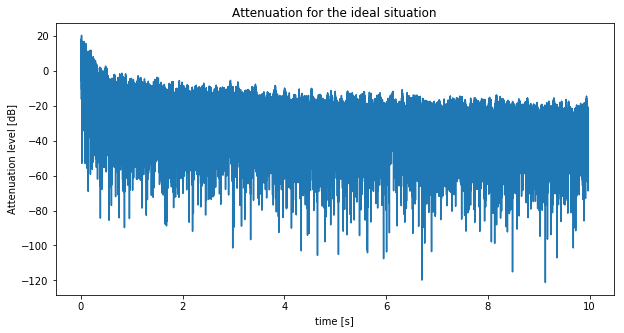

In [10]:
plt.figure(figsize=(10, 5))
plt.title('Attenuation for the ideal situation')
plt.plot(np.linspace(0, 10, len(e)), 20*np.log10(np.abs(e)))
plt.xlabel('time [s]')
plt.ylabel('Attenuation level [dB]')
plt.show()

## 現実のシステムで観測される状況の場合

$$
e(n) = d(n) + G * w * x(n)
$$

In [0]:
# initialize FIR filter and errors
w_real =  np.random.randn(numtaps)
e_real = np.zeros(duration)

# initialize w * x convolution
wx = np.zeros(duration + numtaps - 1)

for i in range(duration - numtaps):
    wx[1:] = wx[:len(wx) - 1]
    wx[0] = w_real.T.dot(x[i : i + numtaps]) # w * x convolution
    y = g.T.dot(wx[:len(g)]) # g * w * x convolution
    e_real[i] = d[i] + y
    w_real = w_real - alpha * r[i : i + numtaps] * e_real[i]

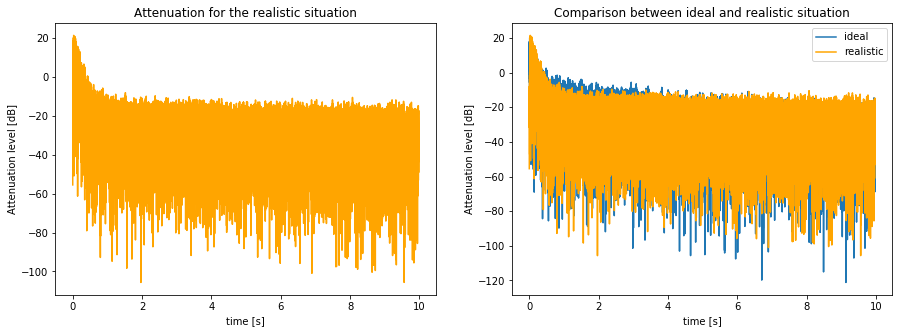

In [12]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Attenuation for the realistic situation')
plt.plot(np.linspace(0, 10, len(e_real)), 20*np.log10(np.abs(e_real)), c='orange')
plt.xlabel('time [s]')
plt.ylabel('Attenuation level [dB]')

plt.subplot(1, 2, 2)
plt.plot(np.linspace(0, 10, len(e)), 20*np.log10(np.abs(e)), label="ideal")
plt.plot(np.linspace(0, 10, len(e_real)), 20*np.log10(np.abs(e_real)), label="realistic", c='orange')
plt.title('Comparison between ideal and realistic situation')
plt.xlabel('time [s]')
plt.ylabel('Attenuation level [dB]')
plt.legend()

plt.show()

## Leaky LMSフィルタの場合

In [0]:
w_leaky = np.random.randn(numtaps) # FIR filter
e_leaky = np.zeros(duration) # Error signal (10s)
alpha = 0.001 # step size
beta = 0.05

r = np.convolve(g, x)

for i in range(0, duration - numtaps):
    e_leaky[i] = d[i] + np.dot(w_leaky.T, r[i : i + numtaps])
    w_leaky = (1 - alpha * beta) * w_leaky - alpha * r[i : i + numtaps] * e_leaky[i]

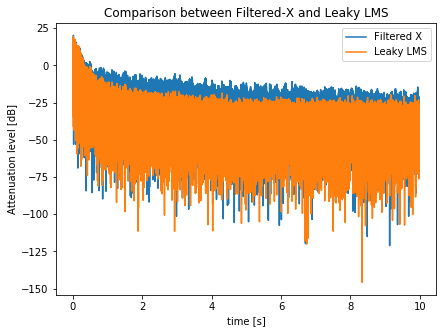

In [14]:
plt.figure(figsize=(15, 5))

plt.title('Attenuation for Leaky LMS algorithm')
plt.plot(np.linspace(0, 10, len(e_leaky)), 20*np.log10(np.abs(e_leaky)))
plt.xlabel('time [s]')
plt.ylabel('Attenuation level [dB]')

plt.subplot(1, 2, 2)
plt.plot(np.linspace(0, 10, len(e)), 20*np.log10(np.abs(e)), label="Filtered X")
plt.plot(np.linspace(0, 10, len(e_leaky)), 20*np.log10(np.abs(e_leaky)), label="Leaky LMS")
plt.title('Comparison between Filtered-X and Leaky LMS')
plt.xlabel('time [s]')
plt.ylabel('Attenuation level [dB]')
plt.legend()

plt.show()

今回の場合、Leaky LMSアルゴリズムのほうが通常のFiltered Xアルゴリズムより早く減衰した。